# Statistical models for Time Series forecasting

Time Series forecasting has some peculiarities that requires methods tailored to them. In this notebook, I explore:
- Autoregression (AR)
- Moving Average (MA)
- Autoregression Integrated Moving Average (ARIMA)
- Seasonal ARIMA (SARIMA)

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import warnings
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [2]:
# Plotting functions
def plot_lineplot_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.lineplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

def plot_scatter_time_series(data, x, y):
    
    # Basic plotting
    plt.figure(figsize=(15,5))
    sns.scatterplot(data=data, x=x, y=y)

    # Format tick labels
    plt.xticks(rotation=45)

# 0. Load Source Data
## 0.1 Air Passangers Dataset

In [3]:
AirPassengers = pd.read_csv("./datasets/AirPassengers.csv")
AirPassengers['Month'] = pd.to_datetime(AirPassengers['Month'])
AirPassengers = AirPassengers.set_index('Month')
AirPassengers.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


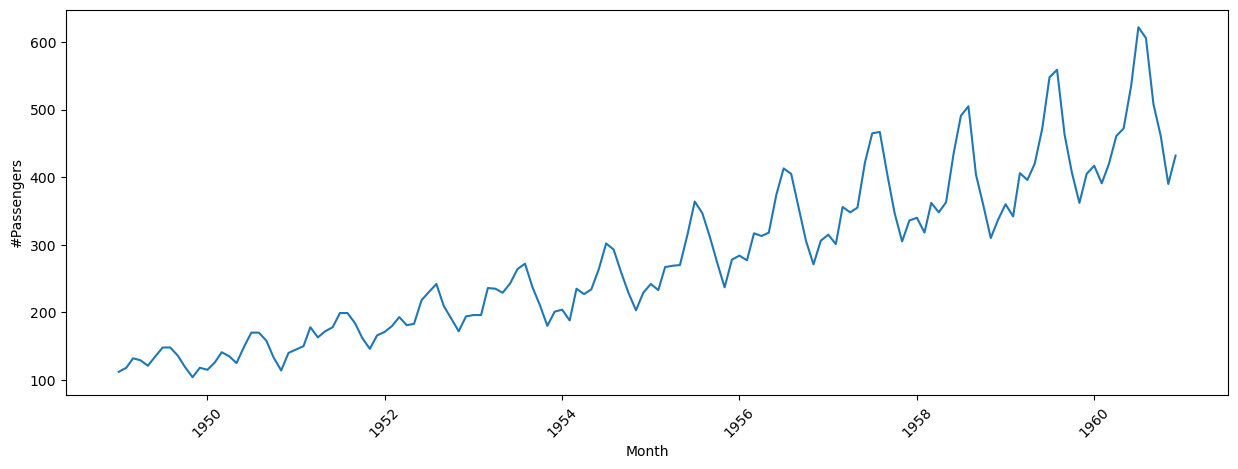

In [4]:
plot_lineplot_time_series(AirPassengers, "Month", "#Passengers")

# 1. Check Stationarity

The initial AirPassengers dataset is clearly not stationary, as the AD Fuller test has a p-value of 0.99.

However, if we decompose the signal between its trend and seasonal components, the seasonal trend is stationary. This provides us a good testbench to test how different algorithms perform on different waves.

In [5]:
result = adfuller(AirPassengers['#Passengers'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [6]:
# Decompose the seasonal data
decomposition_result = seasonal_decompose(AirPassengers['#Passengers'], model='additive')

# Run AD Fuller only on seasonal
adf_result = adfuller(decomposition_result.seasonal)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])

ADF Statistic: -4719265267567261.0
p-value: 0.0
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


In [7]:
AirPassengers['Seasonal Passengers'] = decomposition_result.seasonal
AirPassengers.head(100)

,#Passengers,Seasonal Passengers
Month,,
1949-01-01,112,-24.748737
1949-02-01,118,-36.188131
1949-03-01,132,-2.241162
1949-04-01,129,-8.036616
1949-05-01,121,-4.506313
...,...,...
1956-12-01,306,-28.619949
1957-01-01,315,-24.748737
1957-02-01,301,-36.188131


# 1.1. ACF and PACF plots

These plots help us further understand the effect of the decomposition. The results are the expected:
- The raw # of passengers presents a ACF with a clear correlation at the yearly level, with significant components in the next month and a yearly level.
- The seasonal trend PACF shows that most seasonal components are correlated to each other (unsurprisingly). 

This information help us set the values for the ARIMA process.

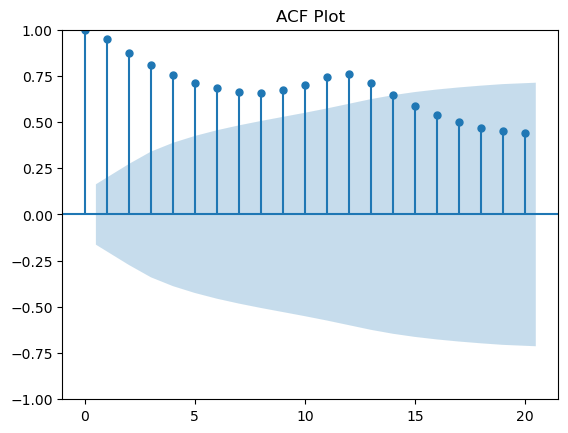

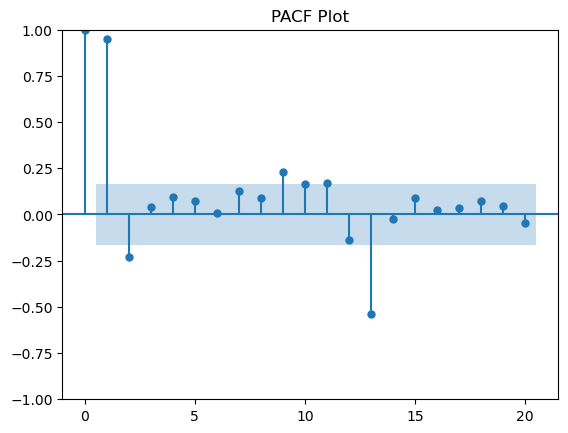

In [8]:
# Looking at the ACF and PACF
# plot ACF
plot_acf(AirPassengers['#Passengers'], lags=20)
plt.title("ACF Plot")
plt.show()

# plot PACF
plot_pacf(AirPassengers['#Passengers'], lags=20)
plt.title("PACF Plot")
plt.show()

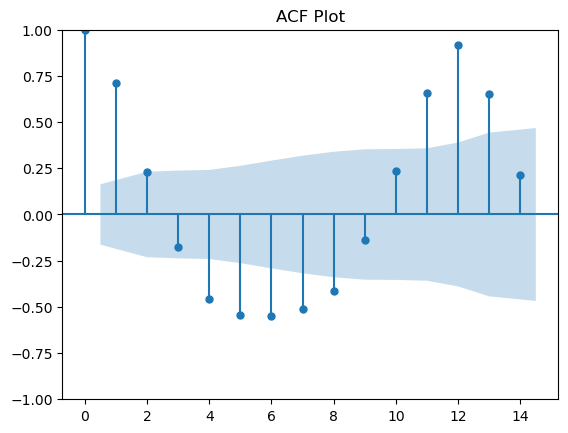

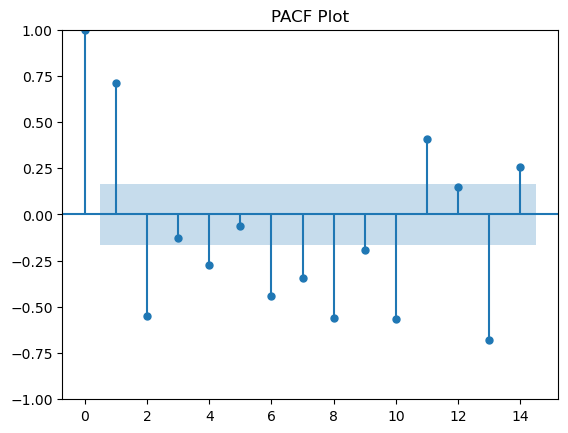

In [9]:
# Looking at the ACF and PACF
# plot ACF
plot_acf(AirPassengers['Seasonal Passengers'], lags=14)
plt.title("ACF Plot")
plt.show()

# plot PACF
plot_pacf(AirPassengers['Seasonal Passengers'], lags=14)
plt.title("PACF Plot")
plt.show()

# 2. Statistical Modelling
## 2.0. Preparing the data

In [10]:
# Raw data
data = AirPassengers['#Passengers']

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Seasonal data
data = AirPassengers['Seasonal Passengers']

# Split data into training and testing sets
train_size = int(len(data) * 0.8)
season_train_data, season_test_data = data[:train_size], data[train_size:]


## 2.1. Autoregression (AR)

Here, I apply an AR to both the raw data and the seasonal data.
- AR performs a suboptimal job in the raw data, due to the lack of stationarity
- AR matches perfectly the seasonal data - too good. This makes me think that this seasonality is generated using an AR.

In [11]:
def run_AR_analysis(train_data, test_data, p):

    # Train AR model
    ar_model = AutoReg(train_data, lags=p)
    ar_model_fit = ar_model.fit()

    # Make predictions on the testing data
    ar_predictions = ar_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

    # Calculate RMSE
    ar_rmse = np.sqrt(mean_squared_error(test_data, ar_predictions))

    # Visualize AR model performance
    plt.plot(test_data, label="Actual")
    plt.plot(ar_predictions, color="red", label="AR Predictions")
    plt.legend()
    plt.title(f"AR Model (p={p})\nRMSE: {ar_rmse:.2f}")
    plt.show()

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


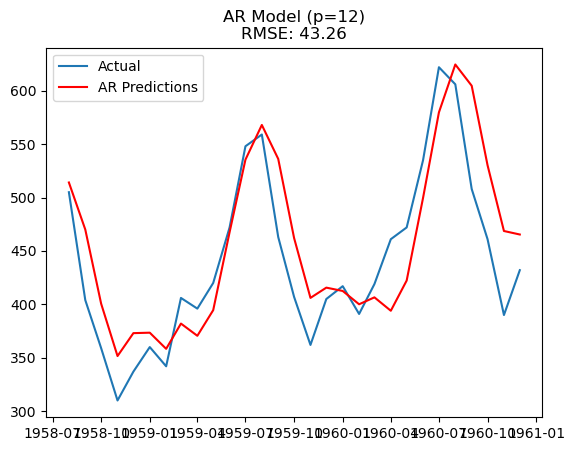

In [12]:
run_AR_analysis(train_data=train_data, test_data=test_data, p=12)

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


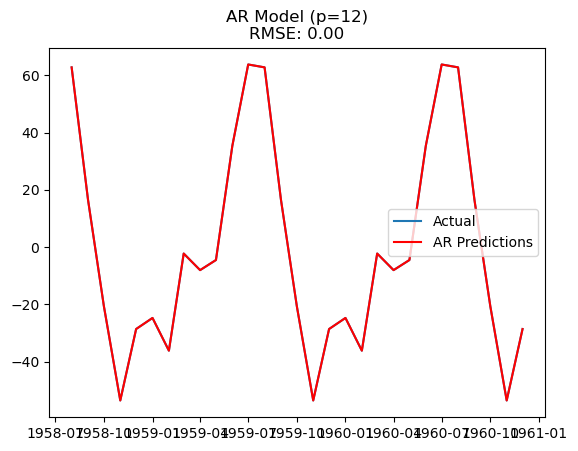

In [13]:
run_AR_analysis(train_data=season_train_data, test_data=season_test_data, p=12)

## 2.2. MA Analysis

The MA component has the problem that it is not good at predicting long-term trends, as it merges to the mean. 
This is exactly what we have found here.

In [14]:
def run_MA_analysis(train_data, test_data, q):

    # Train MA model
    ma_model = ARIMA(train_data, order=(0, 0, q))
    ma_model_fit = ma_model.fit()

    # Make predictions on the testing data
    ma_predictions = ma_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

    # Calculate RMSE
    ma_rmse = np.sqrt(mean_squared_error(test_data, ma_predictions))

    # Visualize AR model performance
    plt.plot(test_data, label="Actual")
    plt.plot(ma_predictions, color="red", label="MA Predictions")
    plt.legend()
    plt.title(f"MA Model (q={q})\nRMSE: {ma_rmse:.2f}")
    plt.show()

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible sta

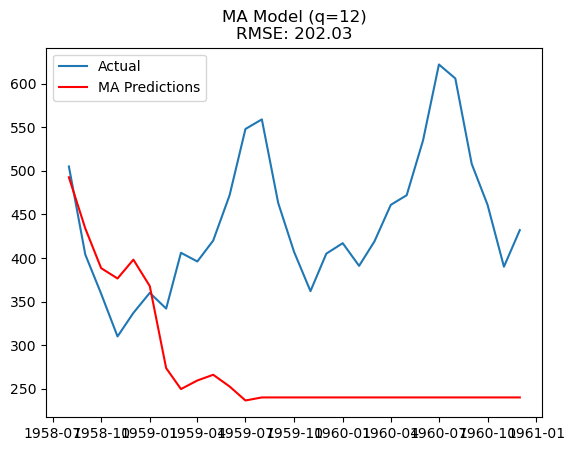

In [15]:
run_MA_analysis(train_data=train_data, test_data=test_data, q=12)

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible sta

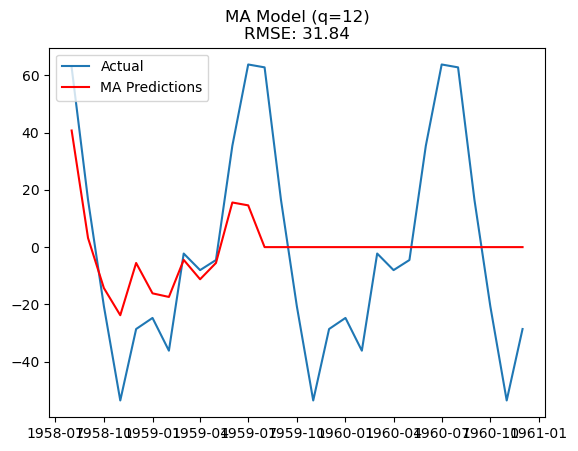

In [16]:
run_MA_analysis(train_data=season_train_data, test_data=season_test_data, q=12)

## 2.3. ARIMA Model

Last but not least, I look at the ARIMA model. I implement two functions:
- One where you can manually specify the parameters
- One that automatically finds the optimal parameters for you

In [17]:
def run_manual_ARIMA_analysis(train_data, test_data, p, d, q):

    # Train ARIMA model
    arima_model = ARIMA(train_data, order=(p, d, q))
    arima_model_fit = arima_model.fit()

    # Make predictions on the testing data
    arima_predictions = arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

    # Calculate RMSE
    arima_rmse = np.sqrt(mean_squared_error(test_data, arima_predictions))

    # Visualize AR model performance
    plt.plot(test_data, label="Actual")
    plt.plot(arima_predictions, color="red", label="MA Predictions")
    plt.legend()
    plt.title(f"ARIMA Model (p={p}, d={d}, q={q})\nRMSE: {arima_rmse:.2f}")
    plt.show()

/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-st

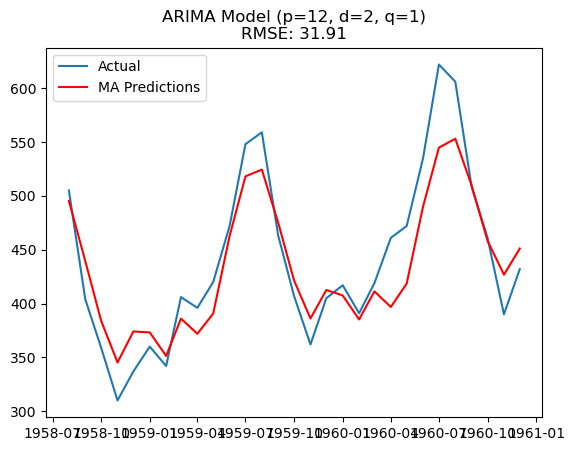

In [18]:
run_manual_ARIMA_analysis(train_data=train_data, test_data=test_data, p=12, d=2, q=1)

In [23]:
def run_auto_ARIMA_analysis(train_data, test_data, p_range, d_range, q_range):

    # Define parameter ranges
    param_combinations = product(p_range, d_range, q_range)

    best_aic = float("inf")
    best_params = None

    for params in tqdm(param_combinations):

        warnings.filterwarnings("ignore")

        p, d, q = params
        arima_model = ARIMA(train_data, order=(p, d, q))

        arima_model_fit = arima_model.fit()
        aic = arima_model_fit.aic

        warnings.resetwarnings()

        if aic < best_aic:
            best_aic = aic
            best_params = params

    # Train ARIMA model with best parameters
    p, d, q = best_params
    best_arima_model = ARIMA(train_data, order=(p, d, q))
    best_arima_model_fit = best_arima_model.fit()

    # Make predictions
    best_arima_predictions = best_arima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

    # Calculate RMSE
    best_arima_rmse = np.sqrt(mean_squared_error(test_data, best_arima_predictions))

    # Visualize ARIMA model performance
    plt.plot(test_data, label="Actual")
    plt.plot(best_arima_predictions, color="red", label="Best ARIMA Predictions")
    plt.legend()
    plt.title(f"Best ARIMA Model (p={p}, d={d}, q={q})\nRMSE: {best_arima_rmse:.2f}")
    plt.show()

108it [01:12,  1.48it/s]
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/miguelcachosoblechero/opt/anaconda3/envs/TimeSeries/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


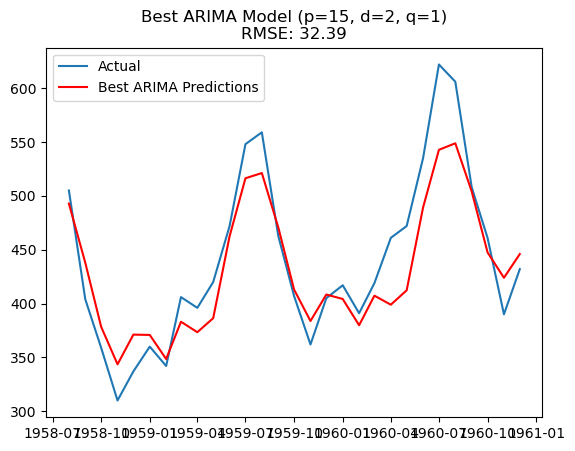

In [24]:
run_auto_ARIMA_analysis(
    train_data=train_data, 
    test_data=test_data, 
    p_range=range(6,24), 
    d_range=range(0,3), 
    q_range=range(0,2)
    )

## 2.4. SARIMA Model

This SARIMA model captures seasonal patterns as well, and models them as another ARIMA model. I use the same approach as before, using a manual approach and an automatic grid search approach. However, the automatic Grid Search takes too much time. 

In [32]:
def run_manual_SARIMA_analysis(train_data, test_data, p, d, q, P, D, Q):

    # Train SARIMA model
    sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, 12))
    sarima_model_fit = sarima_model.fit()

    # Make predictions on the testing data
    sarima_predictions = sarima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

    # Calculate RMSE
    sarima_rmse = np.sqrt(mean_squared_error(test_data, sarima_predictions))

    # Visualize AR model performance
    plt.plot(test_data, label="Actual")
    plt.plot(sarima_predictions, color="red", label="MA Predictions")
    plt.legend()
    plt.title(f"SARIMA Model\n(p={p}, d={d}, q={q})\n(P={P}, D={D}, Q={Q})\nRMSE: {sarima_rmse:.2f}")
    plt.show()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           24     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30754D+00    |proj g|=  4.67169D-01


 This problem is unconstrained.



At iterate    5    f=  4.02650D+00    |proj g|=  7.09758D-02

At iterate   10    f=  3.93700D+00    |proj g|=  4.06781D-02

At iterate   15    f=  3.74343D+00    |proj g|=  1.53448D-01

At iterate   20    f=  3.65424D+00    |proj g|=  1.38101D-02

At iterate   25    f=  3.64871D+00    |proj g|=  1.86933D-02

At iterate   30    f=  3.63370D+00    |proj g|=  1.94081D-02

At iterate   35    f=  3.63177D+00    |proj g|=  9.20178D-03

At iterate   40    f=  3.63032D+00    |proj g|=  8.81184D-03

At iterate   45    f=  3.62810D+00    |proj g|=  8.33098D-03

At iterate   50    f=  3.62781D+00    |proj g|=  2.27289D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

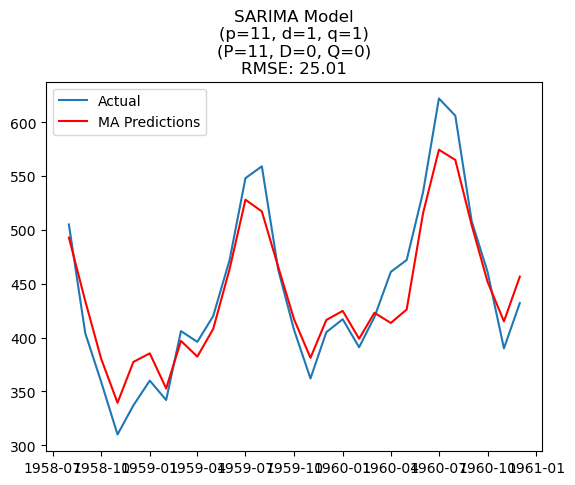

In [34]:
run_manual_SARIMA_analysis(
    train_data=train_data, 
    test_data=test_data, 
    p=11, 
    d=1, 
    q=1,
    P=11,
    D=0,
    Q=0
    )

In [28]:
def run_auto_SARIMA_analysis(train_data, test_data, p_range, d_range, q_range, P_range, D_range, Q_range):

    # Define parameter ranges
    param_combinations = product(p_range, d_range, q_range, P_range, D_range, Q_range)

    best_aic = float("inf")
    best_params = None

    for params in tqdm(param_combinations):

        warnings.filterwarnings("ignore")

        p, d, q, P, D, Q = params
        sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, 12))

        sarima_model_fit = sarima_model.fit()
        aic = sarima_model_fit.aic

        warnings.resetwarnings()

        if aic < best_aic:
            best_aic = aic
            best_params = params

    # Train ARIMA model with best parameters
    p, d, q, P, D, Q = best_params
    best_sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, 12))
    best_sarima_model_fit = best_sarima_model.fit()

    # Make predictions
    best_sarima_predictions = best_sarima_model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

    # Calculate RMSE
    best_sarima_rmse = np.sqrt(mean_squared_error(test_data, best_sarima_predictions))

    # Visualize ARIMA model performance
    plt.plot(test_data, label="Actual")
    plt.plot(best_sarima_predictions, color="red", label="Best SARIMA Predictions")
    plt.legend()
    plt.title(f"Best SARIMA Model\n(p={p}, d={d}, q={q})\n(P={P}, D={D}, Q={Q})\nRMSE: {best_sarima_rmse:.2f}")
    plt.show()

In [ ]:
run_auto_SARIMA_analysis(
    train_data=train_data, 
    test_data=test_data, 
    p_range=range(10,16), 
    d_range=range(0,3), 
    q_range=range(0,2),
    P_range=range(10,16),
    D_range=range(0,1),
    Q_range=range(0,1)
    )